In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
num_bands = 5
fixed_band_indices = [3]
num_fixed_bands = len(fixed_band_indices)

In [3]:
# num_bands, gridsize1, gridsize2, numtypes
stellarmodel_grid = np.zeros((num_bands, 10, 10, 2))
gridsize1, gridsize2, numtypes = stellarmodel_grid.shape[1:4]

# nobj x num_bands
nobj = 100
obsmags = np.random.randn(nobj, num_bands)
obsmags_var = np.random.randn(nobj, num_bands)**2.0

In [4]:
#TODOS:
# add interpolation and/or prior over smoothness of correction
# turn Gaussian likelihood into student-t or something else
# Priors over stellar parameters!

In [5]:
max_correction_magnitude = 0.1
# max amplitude of the correction in magnitude space

In [6]:
# gridsize1: logg
# gridsize2: T

# Grid of stellar models
# Size: num_bands, gridsize1, gridsize2, numtypes
Stellarmodel_grid = tf.placeholder(shape=[num_bands, gridsize1, gridsize2, numtypes], dtype=tf.float32)

# "Lines" of corrections, in the two dimensions
# Defined on R
Corrections_dim1_unbounded = tf.Variable(np.random.randn(num_bands, gridsize1, numtypes), dtype=tf.float32)
Corrections_dim2_unbounded = tf.Variable(np.random.randn(num_bands, gridsize2, numtypes), dtype=tf.float32)

# Set the corrections to zero in the bands that are fixed
Fixed_band_indices = tf.placeholder(shape=[num_fixed_bands, ], dtype=tf.int32)
tf.scatter_update(Corrections_dim1_unbounded, Fixed_band_indices, tf.zeros((num_fixed_bands, gridsize1, numtypes)))
tf.scatter_update(Corrections_dim2_unbounded, Fixed_band_indices, tf.zeros((num_fixed_bands, gridsize1, numtypes)))

# Now we map them to a limited space: [-max_correction_magnitude, +max_correction_magnitude]
# (tf.sigmoid maps R on [0, 1])
Corrections_dim1 = max_correction_magnitude * (2*tf.sigmoid(Corrections_dim1_unbounded) - 1)
Corrections_dim2 = max_correction_magnitude * (2*tf.sigmoid(Corrections_dim2_unbounded) - 1)

# Add the line corrections to form a grid
# Correction(logg, T) = Correction(T) + Correction(logg)
# so the grid is in [-2*max_correction_magnitude, 2*max_correction_magnitude]
# Size: num_bands x gridsize1 x gridsize2 x numtypes
Corrections_grid = Corrections_dim1[:, :, None, :] + Corrections_dim2[:, None, :, :] 

# Apply them to the stellar models
# Size: num_bands, gridsize1, gridsize2, numtypes
Corrected_stellarmodel_grid = Stellarmodel_grid + Corrections_grid

# Now define the observations
# Size: nobj x num_bands
Obsmags = tf.placeholder(shape=[None, num_bands], dtype=tf.float32)
Obsmags_var = tf.placeholder(shape=[None, num_bands], dtype=tf.float32)

# Compute the log likelihoods per object and per model element
# Size: nobj x num_bands x gridsize1, gridsize2, numtypes
Chi2s = tf.divide(
    tf.pow(Obsmags[:, :, None, None, None] - Corrected_stellarmodel_grid[None, :, :, :, :], 2), 
                  Obsmags_var[:, :, None, None, None])
Logdet = tf.log(Obsmags_var[:, :, None, None, None])
# Size: nobj x gridsize1, gridsize2, numtypes
Loglikes = tf.reduce_sum(-0.5 * Chi2s + Logdet, axis=1)

# Finally, compute the log evidence per object and the final log posterior
# Size: nobj
Logevidences = tf.reduce_logsumexp(Loglikes, axis=(1, 2, 3))
# Size: scalar!
MinusLogprob = - tf.reduce_sum(Logevidences, axis=0)

In [7]:
num_iterations = 100
learning_rate = 1e-2

Optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(MinusLogprob)
    
with tf.Session() as sess:

    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # loop: iterations of the optimizer
    for i in range(num_iterations):
        
        subset = np.random.choice(nobj, nobj // 2, replace=False)
        
        _, minuslogprob, corrections_dim1, corrections_dim2 =\
           sess.run([Optimizer, MinusLogprob, Corrections_dim1, Corrections_dim2],
                     feed_dict={
                         Fixed_band_indices: fixed_band_indices,
                         Stellarmodel_grid: stellarmodel_grid,
                         Obsmags: obsmags[subset, :],
                         Obsmags_var: obsmags_var[subset, :],
                     }) 
        
        if i % 10 == 0:
            print('Iteration', i, ': minus log posterior = ', minuslogprob)


Iteration 0 : minus log posterior =  7125.396
Iteration 10 : minus log posterior =  16702.164
Iteration 20 : minus log posterior =  18423.742
Iteration 30 : minus log posterior =  6071.83
Iteration 40 : minus log posterior =  10128.136
Iteration 50 : minus log posterior =  8818.646
Iteration 60 : minus log posterior =  17903.396
Iteration 70 : minus log posterior =  14891.934
Iteration 80 : minus log posterior =  7294.668
Iteration 90 : minus log posterior =  17908.104


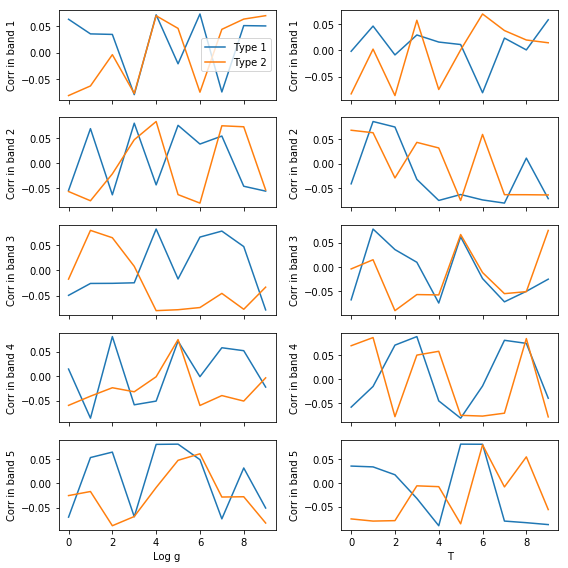

In [8]:
# num_bands, gridsize1, numtypes
fig, axs = plt.subplots(num_bands, 2, figsize=(8, 8), sharex=True)
for i in range(num_bands):
    axs[i, 0].plot(corrections_dim1[i, :, 0], label='Type 1')
    axs[i, 0].plot(corrections_dim1[i, :, 1], label='Type 2')
    axs[i, 1].plot(corrections_dim2[i, :, :])
    axs[i, 0].set_ylabel('Corr in band '+str(i+1))
    axs[i, 1].set_ylabel('Corr in band '+str(i+1))
axs[-1, 0].set_xlabel('Log g')
axs[-1, 1].set_xlabel('T')
axs[0, 0].legend()
fig.tight_layout()